In [1]:
!pip install yfinance QuantLib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 36.6 MB/s eta 0:00:00


### Price using Monte Carlo

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn

''' Default Parameters '''
d_u = 0.0001
d_r = 0.1
d_v = 0.001
d_S0 = 10 # price at t=0
d_h0 = 0 # volatility at the start

d_K = 100 # strike
d_n = 10 # expiry
d_b = 0.95 # beta

In [8]:
def simulate_path(u=d_u, r=d_r, v=d_r, S0=d_S0, h0=d_h0, n=d_n):
    s= np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
      s[t+1] = s[t] + u + (np.exp(h) * randn())
      h = (r * h) + (v * randn())

    return np.exp(s) # a row vector

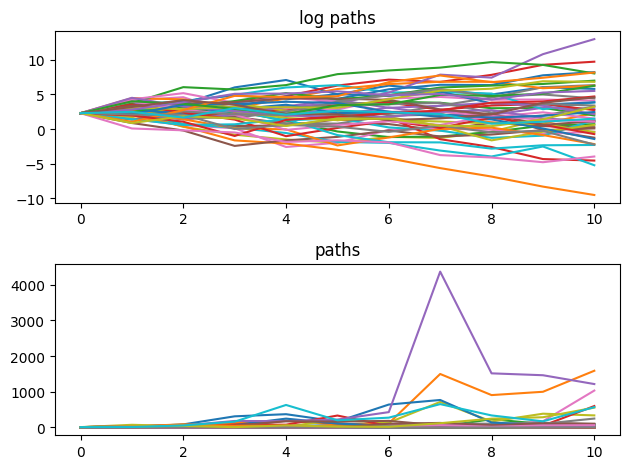

In [9]:
''' Plotting the paths '''

fig, axes = plt.subplots(2, 1)
titles = 'log paths', 'paths'

transforms = np.log, lambda x: x

for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
      path = simulate_path()
      ax.plot(transform(path))

    ax.set_title(title)

fig.tight_layout()
plt.show()

### Problem Statement:

Consider that a European call option may be written on an underlying with spot price of $100 and a knockout barrier of $120.

This option behaves in every way like a vanilla European call, except if the spot price ever moves above $120, the option “knocks out” and the contract is null and void.

Note that the option does not reactivate if the spot price falls below $120 again.

In [10]:
default_μ  = 0.0001
default_ρ  = 0.1
default_ν  = 0.001
default_S0 = 10
default_h0 = 0
default_K = 100
default_n = 10
default_β = 0.95
default_bp = 120

In [11]:
def compute_call_price_with_barrier_vector(β=default_β,
                                           μ=default_μ,
                                           S0=default_S0,
                                           h0=default_h0,
                                           K=default_K,
                                           n=default_n,
                                           ρ=default_ρ,
                                           ν=default_ν,
                                           bp=default_bp,
                                           M=10_000_000):
    s = np.full(M, np.log(S0))
    h = np.full(M, h0)
    option_is_null = np.full(M, False)
    for t in range(n):
        Z = np.random.randn(2, M)
        s = s + μ + np.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
        # Mark all the options null where S_n > barrier price
        option_is_null = np.where(np.exp(s) > bp, True, option_is_null)

    # mark payoff as 0 in the indices where options are null
    payoff = np.where(option_is_null, 0, np.maximum(np.exp(s) - K, 0))
    expectation = np.mean(payoff)
    return β**n * expectation

In [15]:
compute_call_price_with_barrier_vector().item()

0.0384639791179127

# Bayesian Optmisation

In [16]:
!pip install yfinance pandas numpy matplotlib scikit-optimize requests -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.3 MB/s eta 0:00:00


In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
import requests

def get_data_yf(ticker="AAPL", start="2025-01-01", end="2025-05-01"):
    df = yf.download(ticker, start=start, end=end)
    df = df[["Close"]]
    df.dropna(inplace=True)
    return df

data = get_data_yf("RELIANCE.NS")


def backtest_strategy(data, short_window, long_window, stop_loss, take_profit):
    df = data.copy()

    df["SMA_Short"] = df["Close"].rolling(window=short_window).mean()
    df["SMA_Long"] = df["Close"].rolling(window=long_window).mean()

    df.dropna(inplace=True)

    df["Signal"] = 0
    df.loc[df["SMA_Short"] > df["SMA_Long"], "Signal"] = 1
    df.loc[df["SMA_Short"] < df["SMA_Long"], "Signal"] = -1

    df["Return"] = df["Close"].pct_change()
    df["Strategy"] = df["Signal"].shift(1) * df["Return"]

    sharpe = np.mean(df["Strategy"]) / np.std(df["Strategy"]) * np.sqrt(252) if np.std(df["Strategy"]) != 0 else 0
    cagr = (df["Close"].iloc[-1] / df["Close"].iloc[0]) ** (252 / len(df)) - 1
    drawdown = ((1 + df["Strategy"]).cumprod() - (1 + df["Strategy"]).cumprod().cummax()) / (1 + df["Strategy"]).cumprod().cummax()
    return {"sharpe": sharpe, "cagr": cagr, "max_dd": drawdown.min()}


def objective(params):
    short, long, sl, tp = params
    if short >= long:
        return 1e6
    results = backtest_strategy(data, int(short), int(long), sl, tp)
    return -results["sharpe"]


search_space = [
    (1, 5),       # short SMA
    (10, 20),     # long SMA
    (0.01, 0.05),  # stop loss (placeholder)
    (0.05, 0.10)   # take profit (placeholder)
]

result = gp_minimize(objective, search_space, n_calls=40, random_state=42)
print("Best Parameters Found:")
print("Short SMA:", result.x[0])
print("Long SMA:", result.x[1])
print("Stop Loss:", round(result.x[2]*100, 2), "%")
print("Take Profit:", round(result.x[3]*100, 2), "%")
print("Best Sharpe Ratio:", round(-result.fun, 3))

/tmp/ipython-input-1051704451.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Best Parameters Found:
Short SMA: 1
Long SMA: 11
Stop Loss: 3.9 %
Take Profit: 7.66 %
Best Sharpe Ratio: 2.099


In [22]:
!pip install backtesting -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 5.5 MB/s eta 0:00:00


In [43]:
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

df = yf.download("RELIANCE.NS", period="3mo", auto_adjust=True)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] for c in df.columns]

# Rename to exactly what Backtesting.py wants
df = df.rename(columns={
    "Open": "Open",
    "High": "High",
    "Low":  "Low",
    "Close": "Close",
    "Volume": "Volume",
})

df = df[["Open", "High", "Low", "Close", "Volume"]]  # enforce structure

class SMACross(Strategy):
    short = 1
    long = 11
    sl = 0.039
    tp = 0.0766

    def init(self):
        price = self.data.Close
        self.sma_s = self.I(SMA, price, self.short)
        self.sma_l = self.I(SMA, price, self.long)

    def next(self):
        if crossover(self.sma_s, self.sma_l):
            self.buy(sl=self.data.Close[-1] * (1 - self.sl),
                     tp=self.data.Close[-1] * (1 + self.tp))

        if crossover(self.sma_l, self.sma_s):
            self.position.close()


bt = Backtest(df, SMACross,
              cash=1_000_000,
              commission=0.0002,
              trade_on_close=True)

results = bt.run()
results

[*********************100%***********************]  1 of 1 completed


Backtest.run:   0%|          | 0/53 [00:00<?, ?bar/s]

/tmp/ipython-input-13132421.py:47: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  results = bt.run()


,0
Start,2025-09-01 00:00:00
End,2025-12-01 00:00:00
Duration,91 days 00:00:00
Exposure Time [%],25.0
Equity Final [$],1106055.498053
Equity Peak [$],1106055.498053
Commissions [$],1228.309815
Return [%],10.60555
Buy & Hold Return [%],12.248974
Return (Ann.) [%],48.720768


In [44]:
bt.plot()

GridPlot(id='p3090', ...)